# Setup

In [42]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.io
from scipy.spatial import ConvexHull
import seaborn as sns
import sklearn.preprocessing

In [2]:
def grid_gen(coord, ncells, axes = False):
    """
    Generates the grid on which to interpolate the values
    """
    # generate two arrays of evenly space data between ends of previous arrays
    xi = np.linspace(coord[0][0], coord[1][0], ncells[0])
    yi = np.linspace(coord[0][1], coord[1][1], ncells[1])
    if axes:
        return(xi, yi)

    # generate grid 
    xi, yi = np.meshgrid(xi, yi)

    # colapse grid into 1D
    # xi, yi = xi.flatten(), yi.flatten()
    return(xi, yi)

In [3]:
# cwd = os.getcwd()
cwd = 'C:/Users/user/OneDrive - Politecnico di Milano/hydrogeo-modelling/Corsi-dottorato/advanced_geostatistics/assignment_paolo_claudia'

# Load data

In [4]:
#only to merge the database
df = pd.read_csv(os.path.join(cwd, 'data', 'df.csv'))
df.data = pd.to_datetime(df.data, format = '%d/%m/%Y %H:%M')
df = df.sort_values('data')
df = df[['data', 'id_punto', 'x', 'y', 'head']]

df_area_grande =  pd.read_csv(os.path.join(cwd, 'data', 'df_area_grande.csv'))

df_u = pd.concat([df, df_area_grande.loc[df_area_grande.origine == 'MM2023']])
df_u = pd.concat([df_u, df_area_grande.loc[df_area_grande.origine == 'MM2024']])
df_area_grande = df_area_grande[['data', 'id_punto', 'x', 'y', 'head', 'acquifero']]
df_area_grande = df_area_grande.dropna(subset='acquifero')
df_area_grande = df_area_grande.loc[df_area_grande.acquifero.str.contains('ISS'), ['data', 'id_punto', 'x', 'y', 'head']]

df_u = pd.concat([df_u, df_area_grande]).reset_index(drop=True)
df_u.data = pd.to_datetime(df_u.data)
df_u = df_u[['data', 'id_punto', 'x', 'y', 'head']]

# fix references
df.loc[df.id_punto == 'FOG7BIS', 'head'] = df.loc[df.id_punto == 'FOG7BIS', 'head'] - 130.564 + 140.45
df.loc[df.id_punto == 'SAP14', 'head'] = df.loc[df.id_punto == 'SAP14', 'head'] - 136.88 + 137.013

# drop duplicates
df_u = df_u.loc[~df_u.set_index(['data', 'id_punto']).index.duplicated()]

df_u.to_csv(os.path.join(cwd, 'data','df_completo.csv'), index=False)

In [5]:
# to actually load the data needed
df = pd.read_csv(os.path.join(cwd, 'data','df_completo.csv'))
df.data = pd.to_datetime(df.data, format = '%Y-%m-%d')
df = df.sort_values('data').reset_index(drop=True)

In [6]:
df.head()

,data,id_punto,x,y,head
0,2000-01-01,PO1080350U0024,514972.0,5048824.0,134.12
1,2000-01-01,PO108005NU0002,510155.0,5055878.0,178.84
2,2000-02-01,PO108005NU0002,510155.0,5055878.0,178.74
3,2000-02-01,PO1080350U0024,514972.0,5048824.0,133.92
4,2000-03-01,PO108005NU0002,510155.0,5055878.0,178.54


# Obtain IT_DATA.mat (spatial interpolation)

In [7]:
# define the interpolation extention and cell size
# coord = [
#     484083.976265822711866, #xmin
#     5019001.535323087126017,  #ymin
#     521663.116272231447510, #xmax
#     5056468.300624042749405   #ymax
# ]
# reduced area
coord = [
    484209.998149352381006,
    5023597.300505624152720,
    509102.890881214640103,
    5056401.555415857583284
]

dim = 500
# obtain number of rows and columns
nx, ny = round((coord[2] - coord[0])/dim), round((coord[3] - coord[1])/dim)
# obtain the grid cell points
xp, yp = grid_gen([(coord[0], coord[1]), (coord[2], coord[3])], [nx,ny])

In [8]:
df_resample = df.copy()
df_resample = df_resample.pivot_table(values='head', index='data', columns='id_punto')
df_resample = df_resample.resample('1MS').mean()
df_resample = df_resample.reset_index().melt(id_vars='data', value_name='head').dropna().reset_index(drop=True)
df_resample = df_resample.merge(df.drop_duplicates(subset = 'id_punto').loc[:, ['id_punto', 'x', 'y']], on='id_punto', how = 'inner')

In [9]:
# dates with at least 10 data points
count_date = df_resample.sort_values('data').groupby('data').count()
count_date[count_date.id_punto == count_date.id_punto.max()]

,id_punto,head,x,y
data,,,,
2023-09-01,119,119,119,119


In [10]:
# select only one time step
tool = df_resample.loc[df_resample.data == '2023-09-01',:].copy()

# select only points inside coord
tool = tool.loc[((tool.x < coord[2]) & (tool.x > coord[0])) & ((tool.y < coord[3]) & (tool.y > coord[1])),:].copy()

# reset index
tool.reset_index(drop=True, inplace=True)

        data   id_punto     head           x            y
0 2023-09-01  150120152  134.508  500259.579  5036407.488
1 2023-09-01  150120155  135.475  500186.600  5036741.342
2 2023-09-01  150930123  111.664  508969.607  5031354.856
3 2023-09-01  151030234  109.752  502198.765  5025776.520
4 2023-09-01  151461494  113.749  508444.552  5033477.036


<Axes: xlabel='x', ylabel='y'>

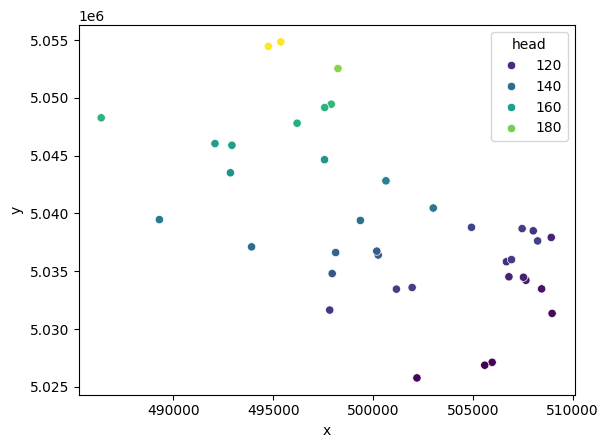

In [11]:
print(tool.head())
sns.scatterplot(tool, x='x', y='y', hue='head', palette='viridis')

In [12]:
# obtain convex hull
points = np.array([tool.x.unique(),tool.y.unique()]).transpose()
hull = ConvexHull(points)

In [13]:
# set data in .mat (Matlab) format
mat = {
    'VAL': np.atleast_2d(tool['head'].values).transpose(),
    'X': np.atleast_2d(tool.x.values).transpose(),
    'XC': np.atleast_2d(hull.points[hull.vertices][:, 0]).transpose(),
    'Y': np.atleast_2d(tool.y.values).transpose(),
    'YC': np.atleast_2d(hull.points[hull.vertices][:, 1]).transpose(),
    'Xp': xp, #coordinates of the prediction points
    'Yp': yp
}

In [63]:
# save as .mat file
scipy.io.savemat(os.path.join(cwd, 'data', 'MAURICE_DATA_v6.mat'), mat)
scipy.io.savemat(os.path.join(cwd, 'code_matlab', 'MAURICE_DATA_v6.mat'), mat)
tool.to_csv(os.path.join(cwd, 'data', 'data_2023_09_v6.csv'), index = False)

## Normalize the data

In [46]:
X = tool['head'].values.reshape(-1, 1)

Y = sklearn.preprocessing.QuantileTransformer(
            output_distribution="normal", random_state=42
        ).fit_transform(X),

c:\Users\user\anaconda3\envs\maurice\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (39). n_quantiles is set to n_samples.
  warnings.warn(


<Axes: xlabel='x', ylabel='y'>

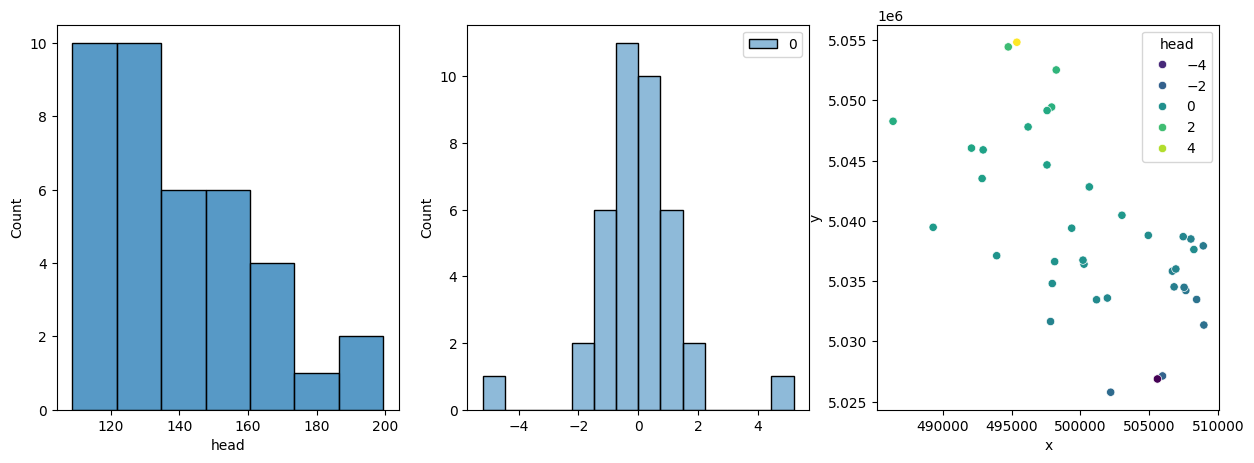

In [54]:
fig, axes = plt.subplots(1,3, figsize =(15,5))
sns.histplot(tool['head'], ax = axes[0])
sns.histplot(Y[0], ax = axes[1])
trash = tool.copy()
trash['head'] = Y[0]
sns.scatterplot(trash, x='x', y='y', hue='head', palette='viridis', ax = axes[2])

In [50]:
# set data in .mat (Matlab) format
mat = {
    'VAL': np.atleast_2d(Y[0]),
    'X': np.atleast_2d(tool.x.values).transpose(),
    'XC': np.atleast_2d(hull.points[hull.vertices][:, 0]).transpose(),
    'Y': np.atleast_2d(tool.y.values).transpose(),
    'YC': np.atleast_2d(hull.points[hull.vertices][:, 1]).transpose(),
    'Xp': xp, #coordinates of the prediction points
    'Yp': yp
}

In [51]:
# save as .mat file
scipy.io.savemat(os.path.join(cwd, 'data', 'MAURICE_DATA_v6_norm.mat'), mat)
scipy.io.savemat(os.path.join(cwd, 'code_matlab', 'MAURICE_DATA_v6_norm.mat'), mat)
tool.to_csv(os.path.join(cwd, 'data', 'data_2023_09_v6_norm.csv'), index = False)

# Obtain TESTD.mat (spatio-temporal kriging)

In [5]:
# define the interpolation extention and cell size
coord = [
    484083.976265822711866, #xmin
    5019001.535323087126017,  #ymin
    521663.116272231447510, #xmax
    5056468.300624042749405   #ymax
]
# cols = ['z', 'id_punto', 'x', 'y']
dim = 100
# obtain number of rows and columns
nx, ny = round((coord[2] - coord[0])/dim), round((coord[3] - coord[1])/dim)
# obtain the grid cell points
xp, yp = grid_gen([(coord[0], coord[1]), (coord[2], coord[3])], [nx,ny])
# extract the same time step as before
tool = df.loc[df.date == '2023-06-01',:].copy()

In [52]:
# dates with at least 10 data points
count_date = df.sort_values('date').groupby('date').count()
d = count_date[count_date.id_punto > 10].index

df10 = df.loc[df.date.isin(d)].reset_index(drop = True)

In [60]:
# add timestep indicator
t = pd.date_range(df10.date[0], df10.date[len(df10.date)-1], freq = '1MS')
i = range(1,len(t)+1)
ti = pd.DataFrame({'t': t, 'i': i})
ts = [ti.loc[t == date, 'i'].values[0] for date in df10.date]
df10['t'] = ts

In [61]:
points = np.array([df10.x.unique(),df10.y.unique()]).transpose()
hull = ConvexHull(points)

In [62]:
# second test: copy TESTD.mat

mat = {
    'VAL': df10.loc[:, ['x','y','t','value']].values,
    'X': np.atleast_2d(df10.x.values).transpose(),
    'XC': np.atleast_2d(hull.points[hull.vertices][:, 0]).transpose(),
    'Y': np.atleast_2d(df10.y.values).transpose(),
    'YC': np.atleast_2d(hull.points[hull.vertices][:, 1]).transpose(),
    'Xp': xp, #coordinates of the prediction points
    'Yp': yp,
    'X2': np.atleast_2d(tool.x.values).transpose(),
    'Y2': np.atleast_2d(tool.y.values).transpose()
}

In [63]:
# save as .mat file
scipy.io.savemat(os.path.join(cwd, 'data', 'TESTD_test.mat'), mat)

# Checks

In [35]:
# dates with at least 10 data points
count_date = df.sort_values('date').groupby('date').count()
d = count_date[count_date.id_punto > 10].index
d_df = pd.DataFrame(index = d).reset_index()
# generate a counter for each date, based on the month
counter = pd.date_range('2009-02-01', '2024-09-01', freq='MS')
counter_df = pd.DataFrame(counter, columns=['date_range'])
counter_df['counter'] = range(0, counter_df.shape[0])
counter_df = counter_df.merge(d_df, how='left', left_on='date_range', right_on='date')
df_clean = df.loc[df.date.isin(d), :].merge(counter_df, left_on = 'date', right_on='date_range').drop(columns = 'date_range')
df_clean = df_clean.sort_values('counter')